In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use("ggplot")
from textwrap import wrap

import pandas as pd


from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from collections import Counter
import string
import nltk
import textstat
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import language_tool_python

from datasets import load_dataset

os.environ["MODIN_ENGINE"] = "dask"


/Users/theodore/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# huggin face dataset
dataset1 = load_dataset("artem9k/ai-text-detection-pile")

df1 = pd.DataFrame(dataset1['train'].to_pandas())
df1 = df1[['text','source']]
df1['source'] = df1['source'].map({'human': 0, 'ai': 1})

# LLM-Detect-AI-Generated-Text
dataset2 = pd.read_csv('LLM-Detect-AI-Generated-Text.csv')

df2 = dataset2[['text','generated']]
df2 = df2.rename(columns={'generated': 'source'})  
df2['source'] = df2['source'].map({0: 0, 1: 1})

# PaLm-Generated-Essays
dataset3 = pd.read_csv('PaLm-Generated-Essays.csv')
df3 = dataset3[['text','generated']]
df3 = df3.rename(columns={'generated': 'source'})  
df3['source'] = df3['source'].map({0.0: 0, 1.0: 1})

# Combined-Set-test
dataset4 = pd.read_csv('Combined-Set-test.csv')
df4 = dataset4[['text','label']]
df4 = df4.rename(columns={'label': 'source'})  
df4['source'] = df4['source'].map({0: 0, 1: 1})

# Combined-Set-train
dataset5 = pd.read_csv('Combined-Set-train.csv')
df5 = dataset5[['text','label']]
df5 = df5.rename(columns={'label': 'source'})  
df5['source'] = df5['source'].map({0: 0, 1: 1})

# AI-vs-Human-Text
dataset6 = pd.read_csv('AI-vs-Human-Text.csv')
df6 = dataset6[['text','generated']]
df6 = df6.rename(columns={'generated': 'source'})  
df6['source'] = df6['source'].map({0.0: 0, 1.0: 1})

# ArguGPT
dataset7 = pd.read_csv('argugpt.csv')
df7 = dataset7[['text']]
df7['source'] = 1

dataset8 = pd.read_csv('machine-train.csv')
df8 = dataset8[['text']]
df8['source'] = 1

dataset9 = pd.read_csv('machine-test.csv')
df9 = dataset9[['text']]
df9['source'] = 1

dataset10 = pd.read_csv('machine-dev.csv')
df10 = dataset10[['text']]
df10['source'] = 1
print(df10)

# Human-vs-LLM-Corpus-Bloom-7B-and-GPT 
dataset11 = pd.read_csv('Human-vs-LLM-Corpus-Bloom-7B-and-GPT.csv')
df11 = dataset11[['text','source']]
df11['source'] = df11['source'].apply(lambda x: 0 if x == 'Human' else 1)
print(df11)




/var/folders/7_/v74xm1tn6zn5xx52z3f4_9b40000gn/T/ipykernel_3914/4082510518.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['source'] = 1
/var/folders/7_/v74xm1tn6zn5xx52z3f4_9b40000gn/T/ipykernel_3914/4082510518.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['source'] = 1
/var/folders/7_/v74xm1tn6zn5xx52z3f4_9b40000gn/T/ipykernel_3914/4082510518.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

                                                  text  source
0    There are a variety of opinions on the purpose...       1
1    The university education is not only for prepa...       1
2    I believe that the university education is mor...       1
3    University education is a topic of much debate...       1
4    The purpose of university education has been a...       1
..                                                 ...     ...
345  The notion that one must be forced to defend a...       1
346  I strongly agree with the statement that menta...       1
347  In today’s world, where competition is highly ...       1
348  Education is one of the most powerful tools th...       1
349  As the world is evolving rapidly, the need for...       1

[350 rows x 2 columns]
                                                     text  source
0       Federal law supersedes state law, and cannabis...       1
1       Miles feels restless after working all day. He...       1
2       So first of I 

/var/folders/7_/v74xm1tn6zn5xx52z3f4_9b40000gn/T/ipykernel_3914/4082510518.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df11['source'] = df11['source'].apply(lambda x: 0 if x == 'Human' else 1)


In [13]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11], ignore_index=True)

In [17]:
df = df1

In [14]:
print(df)



                                                      text  source
0        12 Years a Slave: An Analysis of the Film Essa...       0
1        20+ Social Media Post Ideas to Radically Simpl...       0
2        2022 Russian Invasion of Ukraine in Global Med...       0
3        533 U.S. 27 (2001) Kyllo v. United States: The...       0
4        A Charles Schwab Corporation Case Essay\n\nCha...       0
...                                                    ...     ...
3140843  \nIn the vast expanse of time, where the echoe...       1
3140844  \nThe phenomenon of brain drain, particularly ...       1
3140845  \nThe Influence of Climate Change on Marine Ec...       1
3140846  \nTitle: The Case for Limiting Car Usage: Navi...       1
3140847  \nIn the vast expanse of a globalized society,...       1

[3140848 rows x 2 columns]


In [22]:
df0_text = df[df['source'] == 0].sample(n=10000, random_state=1).copy()  # Sample from df where source is 0
df1_ai = df[df['source'] == 1].sample(n=10000, random_state=1).copy()  # Sample from df where source is 1


#df0_text = df[df['source'] == 0].copy()
#df1_ai = df[df['source'] == 1].copy()

train_df = pd.concat([df0_text,df1_ai], ignore_index=True)

print("Data set size size:", len(train_df))



Data set size size: 20000


In [24]:
print(train_df)

                                                    text  source
0      We've shown you how to get started with the Ra...       0
1      The Novel “Frankenstein” by Mary Shelley Essay...       0
2      Young Penny goes on a retreat with her psychol...       0
3      Evil in “The Lord of the Flies” by William Gol...       0
4      e lived maybe two miles away, so it was a bit ...       0
...                                                  ...     ...
19995  \n\n\n I have read an article suggesting that ...       1
19996  -1800:  With the development of mass-processin...       1
19997  As soon as we heard about the Google Home, we ...       1
19998  \nTo make a cake with meyer lemons, begin by p...       1
19999  The United States' new ambassador to Brazil ha...       1

[20000 rows x 2 columns]


In [20]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/theodore/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/theodore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/theodore/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
from tqdm.notebook import tqdm
from collections import Counter
import string

tool = language_tool_python.LanguageTool('en-US')


# establish stop words and linking words
stop_words = set(stopwords.words('english'))
linking_words = {'to', 'the', 'and', 'of', 'in', 'on', 'for', 'with', 'at', 'a', 'an'}

###
# all_words = []

# Function to tokenize text and remove stopwords
def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words and token not in linking_words]
    return tokens

# # Tokenize all texts and add to all_words
# df0_text['text'].apply(lambda text: all_words.extend(tokenize_text(text)))
# df1_ai['text'].apply(lambda text: all_words.extend(tokenize_text(text)))

# # Count word occurrences
# word_counts = Counter(all_words)

# # Select the top 500 most common words as features
# top_words = [word for word, _ in word_counts.most_common(500)]


def analyze_text(text):
    tokens = word_tokenize(text)
    token_length = len(tokens)
    text_chars = len(text)
    text_words = len(text.split())
    
    title_word_count = sum(token.istitle() for token in tokens)
    
    tokens = [token.lower() for token in tokens]
    
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words and token not in linking_words]
    
    
    linking_words_count = sum(token in linking_words for token in tokens)
        
    counts = Counter(text)

    punctuation_count = sum(counts[char] for char in string.punctuation)

    #punctuation_count_percentage = punctuation_count / token_length * 100 if token_length != 0 else 0
    #linking_words_count_percentage = linking_words_count / token_length * 100 if token_length != 0 else 0
    
    coleman_liau_index = textstat.coleman_liau_index(text)
    
    word_density = text_chars / text_words if text_words != 0 else 0  
    
    matches = len(tool.check(text))
    

    return pd.Series([punctuation_count, coleman_liau_index, word_density, matches, title_word_count, text_words])

# Convert 'text' column to lowercase for df0_text and df1_ai
# df0_text['text'] = df0_text['text'].str.lower()
# df1_ai['text'] = df1_ai['text'].str.lower()



# Apply the analyze_text function to the 'text' column
tqdm.pandas(desc="Processing df0_text")
df0_text[['punctuation_count', 'coleman_liau_index', 'word_density', 'matches', 'title_word_count', 'text_words']] = df0_text['text'].progress_apply(analyze_text)

tqdm.pandas(desc="Processing df1_ai")
df1_ai[['punctuation_count', 'coleman_liau_index', 'word_density', 'matches', 'title_word_count', 'text_words']] = df1_ai['text'].progress_apply(analyze_text)

Processing df0_text:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing df1_ai:   0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
#def count_punctuation_marks(text):
    #punctuation_count = sum(1 for char in text if char in string.punctuation)
    #return punctuation_count

#def count_linking_words(text):
    #linking_words_count = sum(1 for word in word_tokenize(text.lower()) if word in linking_words)
    #return linking_words_count
    
#df0_text['punctuation_count'] = df0_text['text'].apply(count_punctuation_marks)
#df1_ai['punctuation_count'] = df1_ai['text'].apply(count_punctuation_marks)

#df0_text['linking_words_count'] = df0_text['text'].apply(count_linking_words)
#df1_ai['linking_words_count'] = df1_ai['text'].apply(count_linking_words)

In [26]:
df_train = pd.concat([df0_text,df1_ai], ignore_index=False)

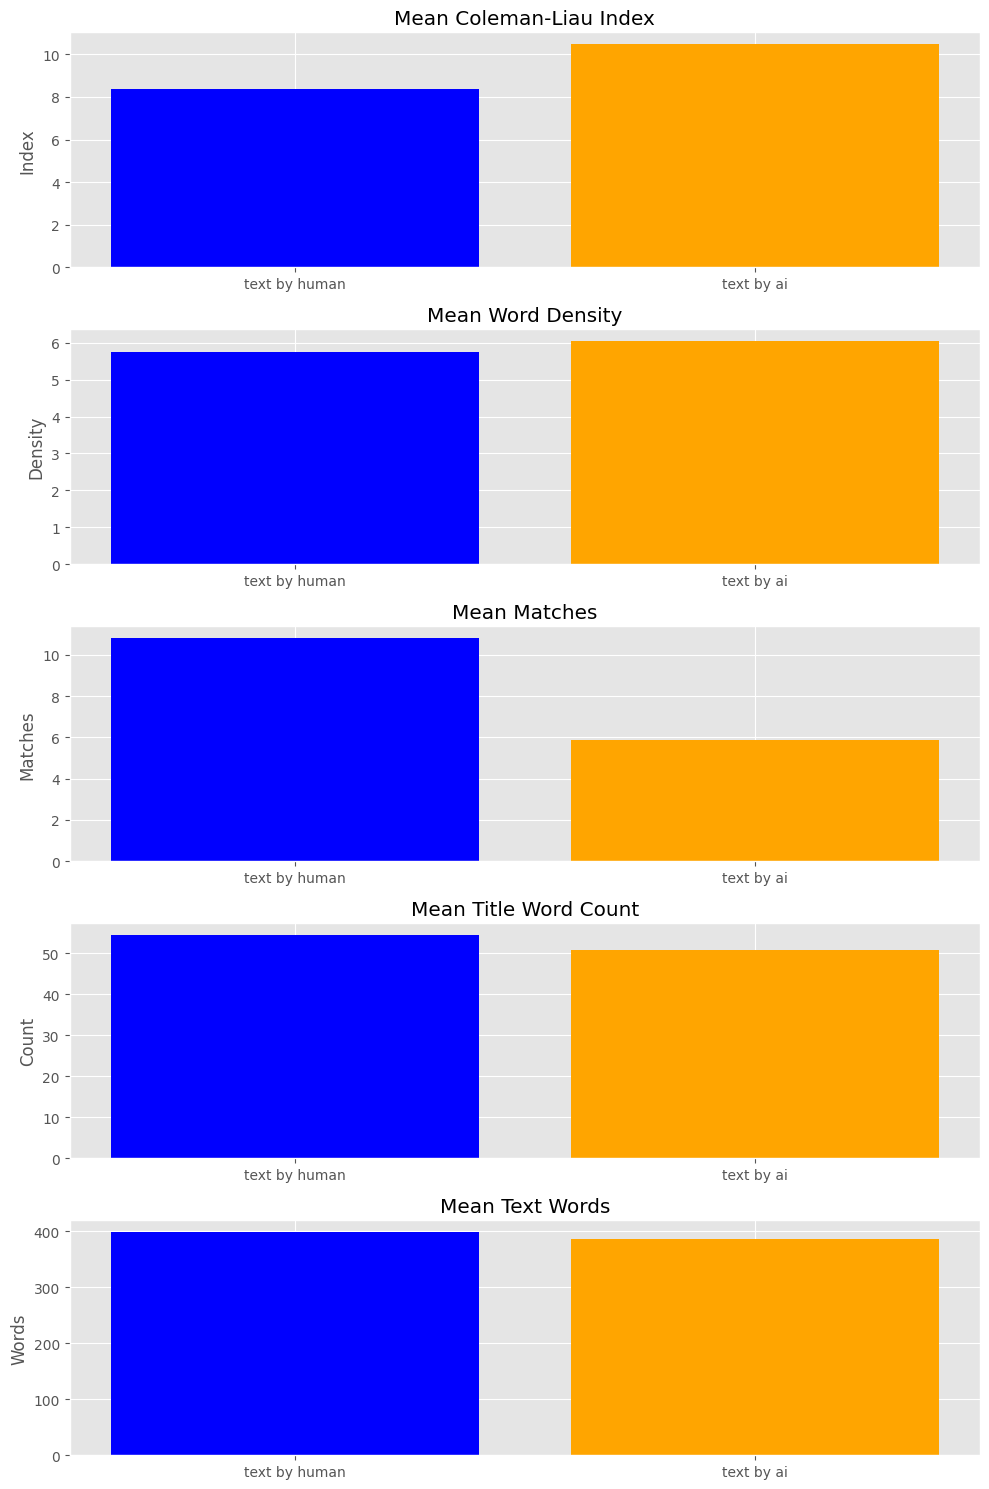

In [27]:
# Calculate the mean for each feature for human texts
human_mean_coleman_liau_index = df0_text.iloc[:]['coleman_liau_index'].mean()
human_mean_word_density = df0_text.iloc[:]['word_density'].mean()
human_mean_matches = df0_text.iloc[:]['matches'].mean()
human_mean_title_word_count = df0_text.iloc[:]['title_word_count'].mean()
human_mean_text_words = df0_text.iloc[:]['text_words'].mean()

# Calculate the mean for each feature for ai texts
ai_mean_coleman_liau_index = df1_ai.iloc[:]['coleman_liau_index'].mean()
ai_mean_word_density = df1_ai.iloc[:]['word_density'].mean()
ai_mean_matches = df1_ai.iloc[:]['matches'].mean()
ai_mean_title_word_count = df1_ai.iloc[:]['title_word_count'].mean()
ai_mean_text_words = df1_ai.iloc[:]['text_words'].mean()

plt.figure(figsize=(10, 15))

plt.subplot(5, 1, 1)
plt.bar(['text by human', 'text by ai'], [human_mean_coleman_liau_index, ai_mean_coleman_liau_index], color=['blue', 'orange'])
plt.title('Mean Coleman-Liau Index')
plt.ylabel('Index')

plt.subplot(5, 1, 2)
plt.bar(['text by human', 'text by ai'], [human_mean_word_density, ai_mean_word_density], color=['blue', 'orange'])
plt.title('Mean Word Density')
plt.ylabel('Density')

plt.subplot(5, 1, 3)
plt.bar(['text by human', 'text by ai'], [human_mean_matches, ai_mean_matches], color=['blue', 'orange'])
plt.title('Mean Matches')
plt.ylabel('Matches')

plt.subplot(5, 1, 4)
plt.bar(['text by human', 'text by ai'], [human_mean_title_word_count, ai_mean_title_word_count], color=['blue', 'orange'])
plt.title('Mean Title Word Count')
plt.ylabel('Count')

plt.subplot(5, 1, 5)
plt.bar(['text by human', 'text by ai'], [human_mean_text_words, ai_mean_text_words], color=['blue', 'orange'])
plt.title('Mean Text Words')
plt.ylabel('Words')

plt.tight_layout()
plt.show()

In [28]:
df_train_copy = df_train.copy()

#df_train_copy.drop(['sentiment_score'], axis=1, inplace=True)
print(df_train_copy.head())
df_train_copy.fillna(0, inplace=True)

df_train_copy

                                                     text  source  \
195932  We've shown you how to get started with the Ra...       0   
875     The Novel “Frankenstein” by Mary Shelley Essay...       0   
343275  Young Penny goes on a retreat with her psychol...       0   
40307   Evil in “The Lord of the Flies” by William Gol...       0   
795950  e lived maybe two miles away, so it was a bit ...       0   

        punctuation_count  coleman_liau_index  word_density  matches  \
195932              124.0                9.70      5.795396     11.0   
875                  88.0               13.81      6.485577     19.0   
343275                4.0                9.98      5.783784      0.0   
40307                83.0                9.58      5.721180      7.0   
795950               55.0                5.75      5.294118      2.0   

        title_word_count  text_words  
195932             126.0       782.0  
875                 62.0       416.0  
343275               3.0        37.

,text,source,punctuation_count,coleman_liau_index,word_density,matches,title_word_count,text_words
195932,We've shown you how to get started with the Ra...,0,124.0,9.70,5.795396,11.0,126.0,782.0
875,The Novel “Frankenstein” by Mary Shelley Essay...,0,88.0,13.81,6.485577,19.0,62.0,416.0
343275,Young Penny goes on a retreat with her psychol...,0,4.0,9.98,5.783784,0.0,3.0,37.0
40307,Evil in “The Lord of the Flies” by William Gol...,0,83.0,9.58,5.721180,7.0,87.0,746.0
795950,"e lived maybe two miles away, so it was a bit ...",0,55.0,5.75,5.294118,2.0,30.0,187.0
...,...,...,...,...,...,...,...,...
1339360,\n\n\n I have read an article suggesting that ...,1,2.0,8.33,6.047619,0.0,3.0,21.0
1352317,-1800: With the development of mass-processin...,1,21.0,9.76,5.768707,1.0,6.0,147.0
1319366,"As soon as we heard about the Google Home, we ...",1,37.0,7.47,5.651163,1.0,29.0,172.0
1051592,"\nTo make a cake with meyer lemons, begin by p...",1,25.0,6.15,5.278571,3.0,11.0,140.0


In [17]:

# # Function to tokenize text and remove stopwords
# def tokenize_text(text):
#     tokens = word_tokenize(text.lower())
#     stop_words = set(stopwords.words('english'))
#     return [token for token in tokens if token.isalpha() and token not in stop_words]

# # Tokenize all texts and count word occurrences
# all_words = [word for text in df_train_copy['text'] for word in tokenize_text(text)]
# word_counts = Counter(all_words)

# # Select the top 500 most common words as features
# top_words = [word for word, _ in word_counts.most_common(500)]

# def featurize_text(row):
#     # Tokenize text and calculate text length
#     tokens = tokenize_text(row['text'])
#     length_text = len(tokens)
    
#     # Calculate word features 
#     word_features = [1 if word in tokens else 0 for word in top_words]
    
#     # Get punctuation and linking words percentages from the dataframe
#     token_length = len(word_tokenize(row['text']))
#     punctuation_count = row['punctuation_count'] / token_length * 100 if token_length != 0 else 0
#     linking_words_count = row['linking_words_count'] / token_length * 100 if token_length != 0 else 0
    
#     return length_text, word_features, punctuation_count, linking_words_count


# tqdm.pandas(desc="Processing df_train_copy")
# # Apply the featurize_text function to the dataframe
# df_train_copy[['length_text', 'word_features', 'punctuation_count_percentage', 'linking_words_percentage']] = df_train_copy.progress_apply(featurize_text, axis=1).apply(pd.Series)
# df_train_copy


In [18]:
# #Function to calculate percentage of punctuation in a text
# def calculate_punctuation_count(text):
#    token_length = len(word_tokenize(text))
#    return count_punctuation_marks(text) / token_length * 100 if token_length != 0 else 0

# df_train_copy['punctuation_count_percentage'] = df_train_copy['text'].apply(calculate_punctuation_count)

# #Function to calculate percentage of linking words in a text
# def calculate_linking_words_count(text):
#    token_length = len(word_tokenize(text))
#    return count_linking_words(text) / token_length * 100 if token_length != 0 else 0

# #Add a column to df0_text for linking words percentage
# df_train_copy['linking_words_percentage'] = df_train_copy['text'].apply(calculate_linking_words_count)

In [29]:
df_train_copy

,text,source,punctuation_count,coleman_liau_index,word_density,matches,title_word_count,text_words
195932,We've shown you how to get started with the Ra...,0,124.0,9.70,5.795396,11.0,126.0,782.0
875,The Novel “Frankenstein” by Mary Shelley Essay...,0,88.0,13.81,6.485577,19.0,62.0,416.0
343275,Young Penny goes on a retreat with her psychol...,0,4.0,9.98,5.783784,0.0,3.0,37.0
40307,Evil in “The Lord of the Flies” by William Gol...,0,83.0,9.58,5.721180,7.0,87.0,746.0
795950,"e lived maybe two miles away, so it was a bit ...",0,55.0,5.75,5.294118,2.0,30.0,187.0
...,...,...,...,...,...,...,...,...
1339360,\n\n\n I have read an article suggesting that ...,1,2.0,8.33,6.047619,0.0,3.0,21.0
1352317,-1800: With the development of mass-processin...,1,21.0,9.76,5.768707,1.0,6.0,147.0
1319366,"As soon as we heard about the Google Home, we ...",1,37.0,7.47,5.651163,1.0,29.0,172.0
1051592,"\nTo make a cake with meyer lemons, begin by p...",1,25.0,6.15,5.278571,3.0,11.0,140.0


Accuracy: 0.678875
Train Loss: 0.6397425870016508
Test Loss: 0.6450721579241364
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.62      0.66      4026
           1       0.66      0.74      0.70      3974

    accuracy                           0.68      8000
   macro avg       0.68      0.68      0.68      8000
weighted avg       0.68      0.68      0.68      8000

Class-wise Metrics:
              precision    recall  f1-score      support
0              0.707965  0.615996  0.658786  4026.000000
1              0.656215  0.742577  0.696730  3974.000000
accuracy       0.678875  0.678875  0.678875     0.678875
macro avg      0.682090  0.679286  0.677758  8000.000000
weighted avg   0.682258  0.678875  0.677635  8000.000000


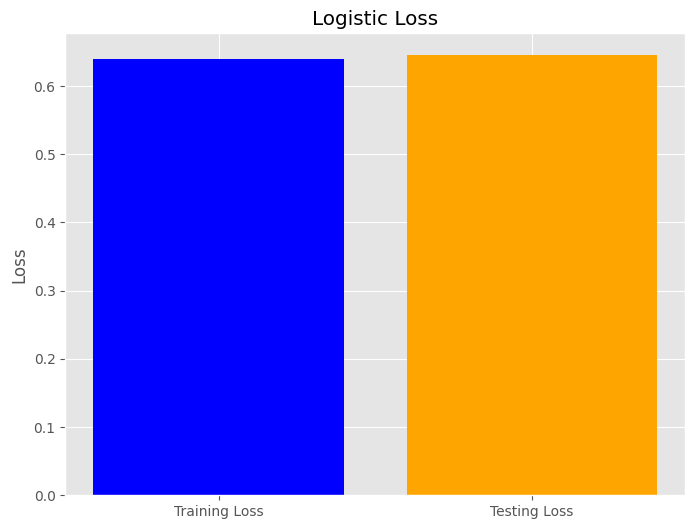

In [30]:
from sklearn import svm, tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Define features (word features, punctuation count, count of synonyms) and target variable
X = pd.DataFrame()


X['punctuation_count'] = df_train_copy['punctuation_count']
X['coleman_liau_index'] = df_train_copy['coleman_liau_index']
X['word_density'] = df_train_copy['word_density']
X['matches'] = df_train_copy['matches']
X['title_word_count'] = df_train_copy['title_word_count']
X['text_words'] = df_train_copy['text_words']

y = df_train_copy['source']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize SimpleImputer, Fit and transform the imputer on the feature matrix X, Initialize and train the Logistic Regression classifier
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
#
model = LogisticRegression(random_state=42)
#model = RandomForestClassifier(random_state=42)
#model = GradientBoostingClassifier(random_state=42) 75%
#model = MLPClassifier() 78%
#model = KNeighborsClassifier() 75% terrible testing loss
#model = AdaBoostClassifier() 75%
#model = xgb.XGBClassifier() 79%
#model = lgb.LGBMClassifier() 79%
#model = CatBoostClassifier() 80%
#
model.fit(X_train_imputed, y_train)


# Make predictions on the testing set
y_pred = model.predict(X_test_imputed)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
train_loss = log_loss(y_train, model.predict_proba(X_train_imputed)) # Calculate logistic loss for training and testing sets
test_loss = log_loss(y_test, model.predict_proba(X_test_imputed))
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

# Calculate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Parse the classification report to get individual class metrics
class_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
print("Class-wise Metrics:")
print(class_report_df)

# Plotting the Loss
loss_values = [train_loss, test_loss]
labels = ['Training Loss', 'Testing Loss']

plt.figure(figsize=(8, 6))
plt.bar(labels, loss_values, color=['blue', 'orange'])
plt.title('Logistic Loss')
plt.ylabel('Loss')
plt.show()

In [89]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "text_classifier_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)

In [95]:
from sklearn.feature_extraction.text import CountVectorizer

# Assuming `model` is your trained model and `imputer` is the SimpleImputer used on your training data
# Also assuming you have a function `analyze_text` that extracts the same features from the text as were used in training the model
test_string = """In recent years, our global community has been navigating through a dynamic economic and political landscape marked by a blend of promising advancements, daunting hurdles, and lingering uncertainties. Economically, the world has witnessed remarkable strides in innovation, propelled by breakthroughs in artificial intelligence, automation, and biotechnology, among other fields. These innovations have not only spurred productivity gains across various sectors but have also catalyzed transformative changes in how we live, work, and interact. However, amidst this progress, there exists a shadow of concern regarding the equitable distribution of these benefits, as well as the potential ramifications of job displacement and wealth concentration.

The phenomenon of globalization continues to exert its influence, weaving intricate webs of economic interdependence among nations through trade, finance, and communication networks. While globalization has undeniably fueled economic growth and facilitated the alleviation of poverty for millions worldwide, it has also brought forth its own set of challenges. Issues such as job displacement in certain sectors, heightened competition, and the erosion of local industries have emerged as significant points of contention, prompting calls for a more nuanced approach to globalization that balances its benefits with the imperatives of social equity and sustainable development.

The seismic shockwaves of the COVID-19 pandemic reverberated across the global economic landscape, disrupting supply chains, shuttering businesses, and plunging economies into turmoil. In response, governments around the world rolled out unprecedented stimulus measures and monetary policies to stabilize their economies and shield vulnerable populations from the worst effects of the crisis. Yet, as the world grapples with the aftermath of the pandemic, the path to recovery remains fraught with uncertainty, with questions lingering about the durability of the rebound and the potential long-term implications for global economic dynamics.

On the political front, our world has witnessed a resurgence of populism, nationalism, and authoritarianism in various corners of the globe. These ideological currents have strained the fabric of liberal democratic institutions and values, giving rise to polarization, social unrest, and a palpable sense of disillusionment among many citizens. Issues such as immigration, nationalism, and identity politics have emerged as flashpoints in political discourse, reshaping electoral landscapes and fueling contentious debates over the direction of our societies.

Geopolitically, tensions between major powers have escalated, punctuating the global stage with a series of diplomatic spats, trade disputes, and strategic rivalries. The competition for resources, influence, and technological supremacy has intensified, raising concerns about the potential for conflict and instability in an increasingly interconnected world. Against this backdrop, the imperative for effective diplomacy, conflict resolution, and multilateral cooperation has never been more pressing, as the consequences of geopolitical tensions reverberate far beyond national borders.

Moreover, our world faces a slew of pressing global challenges, from climate change and cybersecurity threats to pandemics and humanitarian crises. Addressing these challenges demands collective action, solidarity, and a shared commitment to upholding the principles of international cooperation and mutual respect. Yet, the specter of geopolitical rivalries and nationalist agendas threatens to undermine these efforts, underscoring the urgent need for visionary leadership and inclusive policies that transcend narrow interests and foster a more sustainable and equitable global order.

In conclusion, the economic and political state of our world is characterized by a complex tapestry of opportunities and challenges, progress and setbacks, hope and uncertainty. Navigating through these turbulent waters will require steadfast resolve, innovative thinking, and a renewed commitment to forging a future that is inclusive, resilient, and conducive to the well-being of all humankind. Only by working together, in solidarity and cooperation, can we hope to surmount the formidable obstacles that lie ahead and build a better world for generations to come."""

# Preprocess the test string
features = analyze_text(test_string)  # Extract features from the test string

# Convert the features to a DataFrame because the imputer expects a DataFrame
features_df = pd.DataFrame([features], columns=X_train.columns)

# Use the imputer to fill in any missing values
features_imputed = imputer.transform(features_df)

# Classify the test string
prediction = model.predict(features_imputed)

print("The predicted class is:", prediction[0])

The predicted class is: 0
